In [126]:
import h5py
from base import *
from analysis import * 
from compiler import *

path = f'{rootPath}SNe-heated_Gas_Flow/SNeData/expelled_particles.hdf5'
with h5py.File(path) as data:
    print(len(data.keys()), 'Available keys:', *data.keys())

28 Available keys: h148_10 h148_12 h148_2 h148_249 h148_251 h148_27 h148_282 h148_3 h148_34 h148_38 h148_4 h148_55 h148_6 h148_65 h229_14 h229_18 h229_20 h229_22 h229_49 h242_10 h242_21 h242_30 h242_38 h242_69 h242_8 h329_117 h329_29 h329_7


In [3]:
def read_one_expelled(key):
    
    expelled = pd.DataFrame()
    preexpelled = pd.DataFrame()
    expelled = pd.read_hdf(f'{rootPath}SNe-heated_Gas_Flow/SNeData/expelled_particles.hdf5', key=key)
    preexpelled = pd.read_hdf(f'{rootPath}SNe-heated_Gas_Flow/SNeData/preexpelled_particles.hdf5', key=key)

    return preexpelled, expelled

In [9]:
keys = ['h148_10', 'h148_12', 'h148_2', 'h148_249', 'h148_251', 'h148_27', 'h148_282', 'h148_3', 'h148_34', 'h148_38', 'h148_4', 'h148_55',
        'h148_6', 'h148_65', 'h229_14', 'h229_18', 'h229_20', 'h229_22', 'h229_49', 'h242_10', 'h242_21', 'h242_30', 'h242_38',
        'h242_69', 'h242_8', 'h329_117', 'h329_29', 'h329_7']


preexpelled, expelled = read_one_expelled('h329_7')
expelled.head()

,time,pid,rho,temp,mass,coolontime,r,r_per_Rvir,x,y,...,host_r_gal,sat_disk,sat_halo,host_disk,host_halo,other_sat,IGM,sat_Mvir,angle,snHeated
126713,13.262072,164443,0.000118,35127.843750,27204.221237,13.048770,10.053019,0.259517,-1.009866,-9.236422,...,5.213246,False,True,False,False,False,False,6.436547e+09,79.838180,True
108621,12.938837,164635,0.028976,10083.291992,26629.664106,0.000000,2.705981,0.069987,-0.978155,1.304508,...,4.121910,False,True,False,False,False,False,6.550984e+09,93.813379,False
108623,12.938837,164648,0.000449,15654.036133,26754.305851,12.738162,6.443705,0.166658,-3.721039,-3.154299,...,4.121910,False,True,False,False,False,False,6.550984e+09,43.433449,True
36226,11.969131,164680,0.005232,12267.616211,26690.190615,10.881247,3.963844,0.103898,-2.709491,-2.751942,...,5.092050,False,True,False,False,False,False,6.814673e+09,114.652653,False
108635,12.938837,164704,0.010581,11073.396484,26609.706782,12.011726,3.141679,0.081255,-1.061778,-2.853469,...,4.121910,False,True,False,False,False,False,6.550984e+09,98.779589,False


In [11]:
a = np.array([2,4,6,8])
b = np.array([4,6])
import numpy as np
print(np.isin(a,b))

[False  True  True False]


In [23]:
#does counter poduce -1?
from collections import Counter
counter = Counter(np.array([1,1,2,4,5,5,5])) - Counter(np.array([1,2,3,5,5,5,5]))

In [14]:
print(counter)

Counter({1: 1, 4: 1})


## Get the fraction of sn discharged/sn

In [113]:
sim = 'h148'
haloid = 10

particles = read_tracked_particles(sim, haloid)

#all SN-heated gas, which doesn't have to be discharged
coolontime_arr=np.unique(list(zip(particles.index, *map(particles.get, ['pid','time','coolontime']))), axis=0)
disabled_gas_arr = coolontime_arr[1:][coolontime_arr[1:,3]>coolontime_arr[:-1,2]]

indexHeated = disabled_gas_arr[:,0]
heated_all = particles[particles.index.isin(indexHeated)]

> Returning <tracked_particle> dataset <


In [5]:
more_heated2 = pd.read_hdf(f'{rootPath}SNe-heated_Gas_Flow/SNeData/more_heated_particles.hdf5', key='h148_10')

In [293]:
import tqdm
def calc_snHeated(particles):
    """
    This function detects the gas particles that are sn-heated by comparing the coolontime 
    with the time 1 timestep before. Since the detection of sn-heating doesn't depend on any positional argument,
    this includes both particles being discharged and not.
    """
    #iterate detection process by pids
    pids = np.unique(particles['pid'])
    index = np.array([]) #initialize
    for pid in tqdm.tqdm(pids):
        data = particles[particles['pid']==pid]
        #create a structured array, containing index of dataframe, pid, time, and coolontime
        dtype = [('index', int), ('pid', int), ('time', float), ('coolontime', float)]
        structureArray=np.array(list(zip(data.index, *map(data.get, ['pid','time','coolontime']))), dtype=dtype)
        #limit to after being heated (avoid mistakingly take the row heated at the same timestep)
        heatedArray=structureArray[structureArray['time']>structureArray['coolontime']]
        #extract the list of unique coolontime, sorted by pid and time
        helper1, helper2 = np.unique(heatedArray['coolontime'], return_index = True)
        heatedunique = np.sort(heatedArray[helper2], order=['pid','time'])

        timebefore = heatedunique['time'][:-1]
        #find sn-heated list by comparing the time before and coolontime
        heatedLocal = heatedunique[1:][heatedunique['coolontime'][1:]>timebefore]
        indexLocal = heatedLocal['index'].astype(int)
        index = np.append(index, indexLocal)
    #based on detected indices, find the designated rows from original dataframe
    heated = particles[particles.index.isin(index)] 

    return heated

> Returning <tracked_particle> dataset <
> Returning (predischarged, discharged, hot_predischarged) for satellite h148_10 <


/tmp/ipykernel_25924/748910392.py:30: RuntimeWarning: invalid value encountered in scalar divide
  ratioDis = dist[i]/snt[i]
/tmp/ipykernel_25924/748910392.py:31: RuntimeWarning: invalid value encountered in scalar divide
  ratioExp = expt[i]/snt[i]


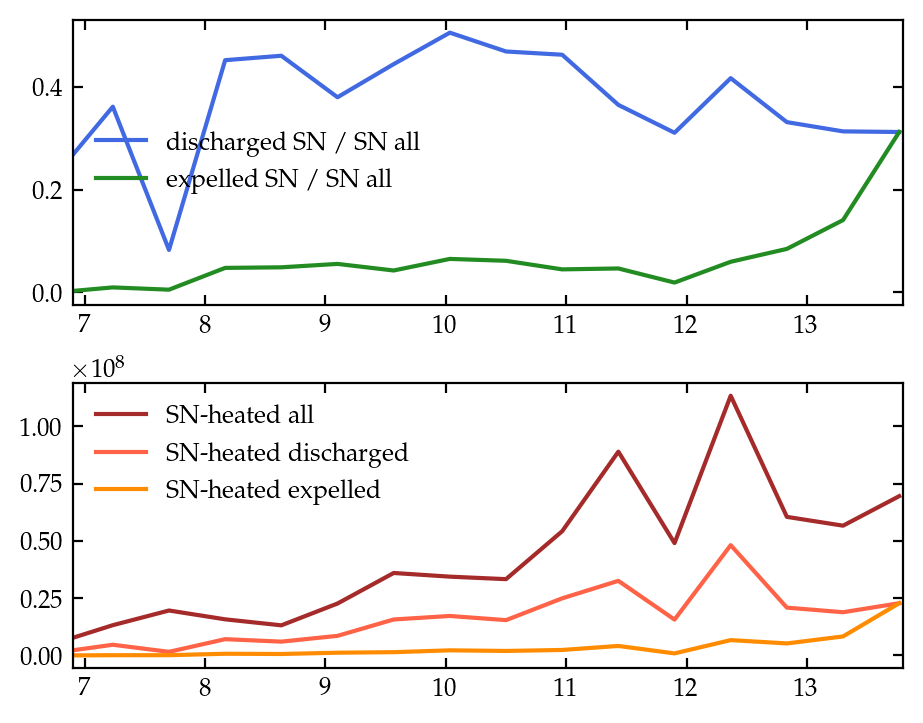

In [124]:
#fraction of discharged/heated
# all discharged gas
bins = 30
rangeMax = 14

#load particles
sim = 'h148'
haloid = 10
particles = read_tracked_particles(sim, haloid)

#discharged sn-heated gas, binned
_, discharged = read_one_discharged('h148_10')
heated_dis = calc_snHeated(discharged)
dist, x = np.histogram(heated_dis.time, bins=bins, range=(0,rangeMax))

# all snheated gas, binned
heated_all = calc_snHeated(particles)
snt, x = np.histogram(heated_all.time, bins=bins, range=(0,rangeMax))

#expelled sn-heated gas, binned
_, expelled = read_one_expelled('h148_10')
heated2 = calc_snHeated(expelled)
expt, x = np.histogram(heated2.time, bins=bins, range=(0,rangeMax))

# computing fraction dist/snt at each radial position.
fracDis = np.array([])
fracExp = np.array([])

for i in range(0, bins):
    ratioDis = dist[i]/snt[i]
    ratioExp = expt[i]/snt[i]
    fracDis = np.append(fracDis,ratioDis)
    fracExp = np.append(fracExp,ratioExp)
    i += 1


fig, ax = plt.subplots(2,1,figsize = (4.5,3.5))
# fraction sne/all:
bincenters = 0.5*(x[1:] + x[:-1])
ax[0].plot(bincenters, fracDis, c = 'royalblue', label='discharged SN / SN all')
ax[0].plot(bincenters, fracExp, c = 'forestgreen', label='expelled SN / SN all')
ax[0].set_xlim(np.min(heated_dis.time), np.max(heated_dis.time))
ax[0].legend(fontsize=7,loc='upper left')

# mass distributions:
# all snheated gas
snall, x = np.histogram(heated_all.time, bins=bins, weights=heated_all.mass, range=(0,rangeMax))
snexpelled, x = np.histogram(heated2.time, bins=bins, weights=heated2.mass, range=(0,rangeMax))
sndischarged, x = np.histogram(heated_dis.time, bins=bins, weights=heated_dis.mass, range=(0,rangeMax))

bincenters = 0.5*(x[1:] + x[:-1])
ax[1].plot(bincenters, snall, label='SN-heated all', c='brown')
ax[1].plot(bincenters, sndischarged, label='SN-heated discharged', c='tomato')
ax[1].plot(bincenters, snexpelled, label='SN-heated expelled', c='darkorange')
ax[1].set_xlim(np.min(heated_dis.time), np.max(heated_dis.time))
ax[1].legend(fontsize=7,loc='upper left')

> Returning <tracked_particle> dataset <


100%|████████████████████████████████████| 89554/89554 [03:30<00:00, 425.69it/s]


> Returning (predischarged, discharged, hot_predischarged) for satellite h148_10 <


/tmp/ipykernel_25924/1934909811.py:47: RuntimeWarning: invalid value encountered in scalar divide
  ratioDis = dist[i]/snt[i]
/tmp/ipykernel_25924/1934909811.py:48: RuntimeWarning: invalid value encountered in scalar divide
  ratioExp = expt[i]/snt[i]


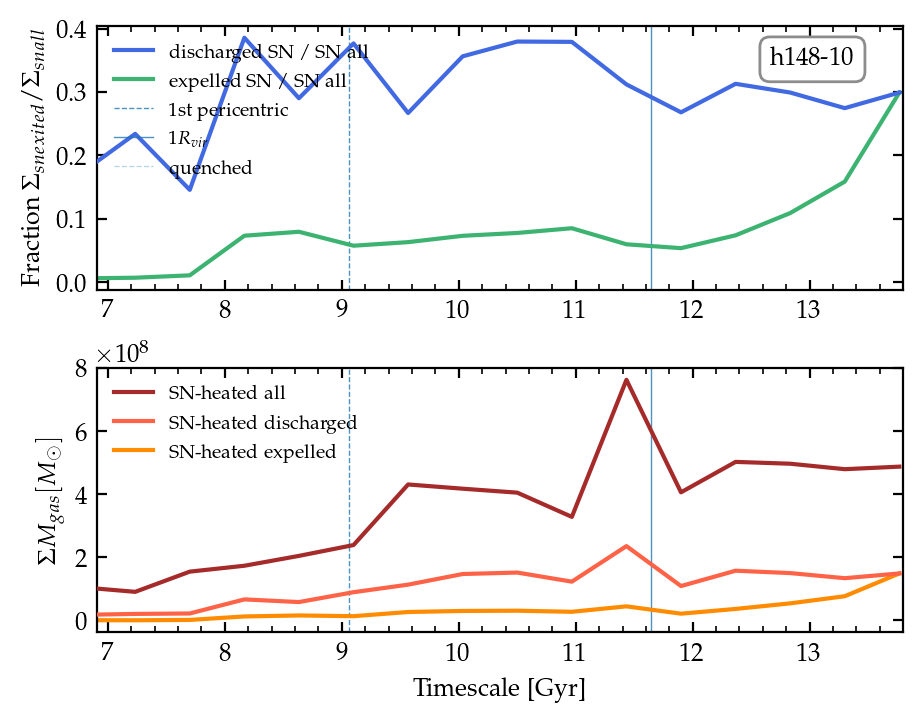

> Returning <tracked_particle> dataset <


100%|█████████████████████████████████████| 9978/9978 [00:06<00:00, 1529.95it/s]


> Returning (predischarged, discharged, hot_predischarged) for satellite h148_12 <


/tmp/ipykernel_25924/1934909811.py:47: RuntimeWarning: invalid value encountered in scalar divide
  ratioDis = dist[i]/snt[i]
/tmp/ipykernel_25924/1934909811.py:48: RuntimeWarning: invalid value encountered in scalar divide
  ratioExp = expt[i]/snt[i]


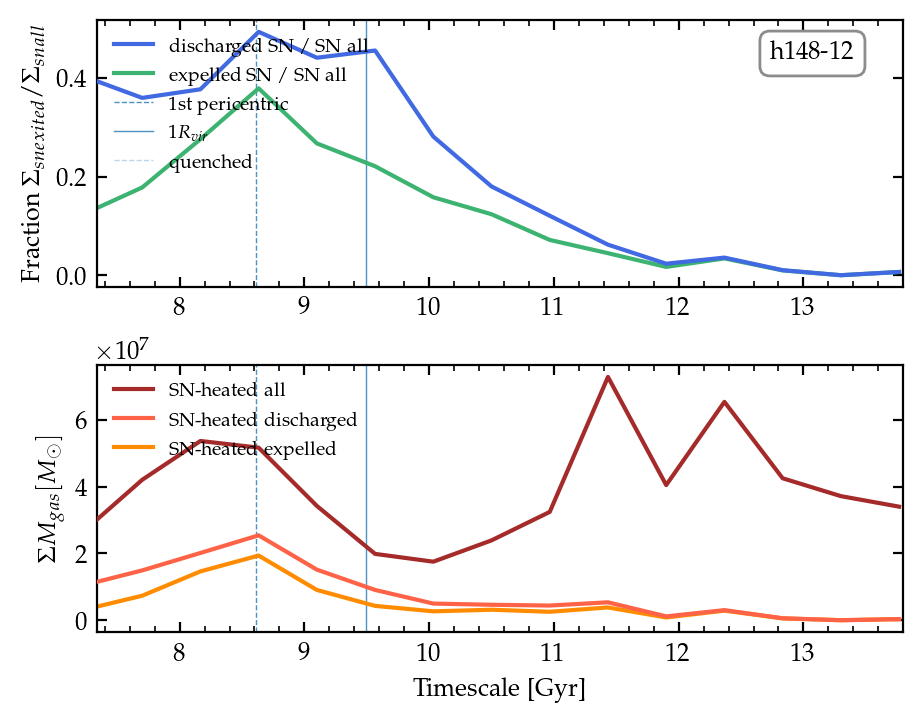

> Returning <tracked_particle> dataset <


100%|█████████████████████████████████▉| 496470/496963 [47:24<00:03, 163.24it/s]

In [295]:
import time
keys = ['h148_10', 'h148_12', 'h148_2', 'h148_249', 'h148_251', 'h148_27', 'h148_282', 'h148_3', 'h148_34', 'h148_38', 'h148_4', 'h148_55',
        'h148_6', 'h148_65', 'h229_14', 'h229_18', 'h229_20', 'h229_22', 'h229_49', 'h242_10', 'h242_21', 'h242_30', 'h242_38',
        'h242_69', 'h242_8', 'h329_117', 'h329_29', 'h329_7']

start = time.time()
#load distance from host information
r_data = pd.read_csv(f'{rootPath}SNe-heated_Gas_Flow/SNeData/all-satellite-information.csv')
    
for key in keys:
    #run for all other satellites
    
    #fraction of discharged/heated
    bins = 30
    rangeMax = 14

    #load particles
    sim = str(key[:4])
    haloid = int(key[5:])
    particles = read_tracked_particles(sim, haloid)

    # all snheated gas, binned
    heated_all = calc_snHeated(particles) #7/25 redefined
    #save
    filepath = f'{rootPath}SNe-heated_Gas_Flow/SNeData/heated_all_particles.hdf5'
    heated_all.to_hdf(filepath, key=key)
    #bin
    snt, x = np.histogram(heated_all.time, bins=bins, range=(0,rangeMax))
    
    #discharged sn-heated gas, binned
    _, discharged = read_one_discharged(key)
    heated_dis = discharged[discharged['snHeated']==True].drop_duplicates(subset=['pid', 'time'])
    #bin
    dist, x = np.histogram(heated_dis.time, bins=bins, range=(0,rangeMax))

    #expelled sn-heated gas, binned
    _, expelled = read_one_expelled(key)
    heated_exp = expelled[expelled['snHeated']==True].drop_duplicates(subset=['pid', 'time'])
    #bin
    expt, x = np.histogram(heated_exp.time, bins=bins, range=(0,rangeMax))

    # computing fraction dist/snt at each radial position.
    fracDis = np.array([])
    fracExp = np.array([])

    for i in range(0, bins):
        ratioDis = dist[i]/snt[i]
        ratioExp = expt[i]/snt[i]
        fracDis = np.append(fracDis,ratioDis)
        fracExp = np.append(fracExp,ratioExp)
        i += 1


    fig, ax = plt.subplots(2,1,figsize = (4.5,3.5))
    # fraction sne/all:
    bincenters = 0.5*(x[1:] + x[:-1])
    ax[0].plot(bincenters, fracDis, c = 'royalblue', label='discharged SN / SN all', zorder = 3)
    ax[0].plot(bincenters, fracExp, c = 'mediumseagreen', label='expelled SN / SN all', zorder = 2)
    ax[0].set_ylabel('Fraction $\Sigma_{sn exited} / \Sigma_{sn all}$')
    ax[0].set_xlim(np.min(heated_dis.time), np.max(heated_dis.time))
    ax[0].tick_params(direction='in',which='both',right=True,top=True)

    
    # mass distributions:
    # all snheated gas
    snall, x = np.histogram(heated_all.time, bins=bins, weights=heated_all.mass, range=(0,rangeMax))
    snexpelled, x = np.histogram(heated_exp.time, bins=bins, weights=heated_exp.mass, range=(0,rangeMax))
    sndischarged, x = np.histogram(heated_dis.time, bins=bins, weights=heated_dis.mass, range=(0,rangeMax))

    bincenters = 0.5*(x[1:] + x[:-1])
    ax[1].plot(bincenters, snall, label='SN-heated all', c='brown', zorder = 4)
    ax[1].plot(bincenters, sndischarged, label='SN-heated discharged', c='tomato', zorder = 3)
    ax[1].plot(bincenters, snexpelled, label='SN-heated expelled', c='darkorange', zorder = 2)
    ax[1].set_xlim(np.min(heated_dis.time), np.max(heated_dis.time))
    ax[1].set_xlabel('Timescale [Gyr]')
    ax[1].set_ylabel('$\Sigma M_{gas} [M_{\odot}]$')
    
    
    #show where it reaches 1 Rvir distant from host, and where it hits the 1st pericentric distance
    r_data_read = r_data[(r_data.sim==sim)&(r_data.haloid==haloid)]
    p_time = float(r_data_read['1st p_time'])
    vir_time = float(r_data_read['t_1Rvir_from_Host'])
    q_time = float(r_data_read['tquench'])
    
    #make a vertical line indicating those instances
    ax[0].axvline(x=p_time, linestyle='dashed', label='1st pericentric', 
                 alpha = 0.8, linewidth = 0.5, zorder = 1)
    ax[1].axvline(x=p_time, linestyle='dashed', alpha = 0.8, linewidth = 0.5, zorder = 1)
    ax[0].axvline(x=vir_time, linestyle='solid', label='$1 R_{vir}$', 
                 alpha = 0.8, linewidth = 0.5, zorder = 1)
    ax[1].axvline(x=vir_time, linestyle='solid', alpha = 0.8, linewidth = 0.5, zorder = 1)
    if not q_time == np.nan: #it's quenched
        ax[0].axvline(x=q_time, linestyle='dashed', label='quenched', 
                     alpha = 0.3, linewidth = 0.5, zorder = 1)
        ax[1].axvline(x=q_time, linestyle='dashed', alpha = 0.3, linewidth = 0.5, zorder = 1)
      
    ax[0].legend(fontsize=7,loc='upper left')
    ax[1].legend(fontsize=7,loc='upper left')
    ax[0].xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.2))
    ax[0].annotate(f"{key.replace('_','-')}", (0.94, 0.92), xycoords='axes fraction', ha='right', va='top',
                bbox=dict(boxstyle='round,pad=0.4', fc='w', ec='0.5', alpha=0.9), zorder=100)
    ax[1].tick_params(direction='in',which='both',right=True,top=True)
    ax[1].xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.2))
    
    #save
    plt.savefig(f'plots/{key}_fracSN_NEW.pdf')
    plt.show()

end = time.time()
print("Program finished execution: ", end - start, " s")

In [258]:
len(heated_dis)

69870

In [47]:
Counter(discharged.pid)

Counter({936805: 1,
         1336093: 2,
         1352518: 1,
         2173227: 2,
         2235729: 3,
         2317970: 3,
         2602227: 2,
         2617848: 2,
         2633295: 1,
         2641844: 2,
         2642651: 1,
         2666892: 3,
         2668564: 1,
         2691146: 1,
         2709586: 1,
         2713926: 3,
         2719821: 3,
         2783370: 3,
         2784669: 2,
         2785629: 2,
         2861255: 2,
         2939528: 3,
         3086130: 2,
         3093134: 2,
         3096408: 1,
         3099954: 2,
         3102716: 1,
         3108906: 1,
         3110702: 2,
         3111024: 1,
         3117486: 3,
         3117659: 2,
         3118321: 1,
         3125123: 1,
         3125339: 2,
         3126992: 2,
         3183198: 2,
         3380109: 1,
         3380123: 2,
         3854031: 1,
         3870572: 1,
         3877532: 1,
         3889067: 3,
         4040705: 1,
         4112916: 1,
         4135434: 1,
         4313141: 1,
         43154

In [115]:
discharged[((discharged.pid==8901053)|(discharged.pid==6933165))&(discharged.snHeated==True)]

,time,pid,rho,temp,mass,coolontime,r,r_per_Rvir,x,y,...,host_r_gal,sat_disk,sat_halo,host_disk,host_halo,other_sat,IGM,sat_Mvir,angle,snHeated
1254056,11.645896,6933165,0.028416,10590.229492,26986.935784,11.219633,2.850509,0.060595,-0.714163,-1.214831,...,21.124828,False,True,False,False,False,False,1.315466e+10,120.219597,True
986995,10.767100,8901053,0.067336,10033.865234,26806.649788,10.483096,5.164755,0.110537,3.296754,2.243037,...,19.057034,False,True,False,False,False,False,1.409881e+10,131.587268,True
1344540,12.076876,8901053,0.026048,10015.593750,27136.101067,11.674182,3.054410,0.064466,1.718132,-1.186382,...,19.769437,False,True,False,False,False,False,1.292568e+10,105.793418,True
1611008,12.938837,8901053,0.033036,9579.974609,27412.274096,12.907493,4.006311,0.084324,0.034498,0.911621,...,17.456248,False,True,False,False,False,False,1.215825e+10,121.618073,True


In [118]:
np.unique(np.diff(test.time))

array([0.        , 0.01683517, 0.07407475, 0.13468137, 0.29629901,
       0.35690563, 0.41077818, 0.41414521, 0.43098038, 0.43098038,
       0.43098038, 0.43098038, 0.43098038, 0.43098038, 0.43098038,
       0.43098038, 0.43098038, 0.43098038, 0.45118259])

In [119]:
particles[2:4]

,time,pid,rho,temp,mass,coolontime,r,r_per_Rvir,x,y,...,dt,r_gal,host_r_gal,sat_disk,sat_halo,host_disk,host_halo,other_sat,IGM,sat_Mvir
2,6.474131,639135,0.000019,42154.210938,26510.536704,0.0,743.057345,20.242159,32.164885,-611.435712,...,0.43098,0.913015,19.59562,False,False,False,False,False,True,1.417260e+10
3,6.474131,690707,0.000167,93560.257812,26510.536704,0.0,669.160153,18.229072,66.143066,-372.504420,...,0.43098,0.913015,19.59562,False,False,False,False,False,True,1.417260e+10


In [238]:
# particles = read_tracked_particles('h148', 10)
test = particles[(particles.pid==8901053) | (particles.pid==6933165)]
dtype = [('index', int), ('pid', int), ('time', float), ('coolontime', float)]
testarray=np.array(list(zip(test.index, *map(test.get, ['pid','time','coolontime']))), dtype=dtype)
#print(testarray)
testarray=testarray[testarray['time']>testarray['coolontime']]
helper1, helper2 = np.unique(testarray['coolontime'], return_index = True)
testunique = np.sort(testarray[helper2], order=['pid','time'])
print(testunique)
pids = np.unique(testunique['pid'])
index = np.array([])
for pid in pids:
    dat = testunique[testunique['pid']==pid]
    timebefore = dat['time'][:-1]
    heatedArray = dat[1:][dat['coolontime'][1:]>timebefore]
    heatedIndex = heatedArray['index'].astype(int)
    index = np.append(index, heatedIndex)
heated = test[test.index.isin(index)]    

[(    826, 6933165,  6.47413103,  0.        )
 (1254056, 6933165, 11.6458956 , 11.21963324)
 (1697930, 6933165, 13.36981712, 13.19776086)
 ( 718472, 8901053,  9.49099369,  9.37366138)
 ( 897498, 8901053, 10.35295445, 10.27817482)
 ( 986995, 8901053, 10.76709966, 10.48309636)
 (1344540, 8901053, 12.07687598, 11.67418171)
 (1611008, 8901053, 12.93883674, 12.90749342)]


In [239]:
heated

,time,pid,rho,temp,mass,coolontime,r,r_per_Rvir,x,y,...,dt,r_gal,host_r_gal,sat_disk,sat_halo,host_disk,host_halo,other_sat,IGM,sat_Mvir
897498,10.352954,8901053,5.042926,1022.113892,26642.461248,10.278175,2.411041,0.051475,2.014559,1.320540,...,0.430980,1.948417,18.796600,True,False,False,False,False,False,1.489011e+10
986995,10.767100,8901053,0.067336,10033.865234,26806.649788,10.483096,5.164755,0.110537,3.296754,2.243037,...,0.414145,3.902642,19.057034,False,True,False,False,False,False,1.409881e+10
1254056,11.645896,6933165,0.028416,10590.229492,26986.935784,11.219633,2.850509,0.060595,-0.714163,-1.214831,...,0.430980,2.229377,21.124828,False,True,False,False,False,False,1.315466e+10
1344540,12.076876,8901053,0.026048,10015.593750,27136.101067,11.674182,3.054410,0.064466,1.718132,-1.186382,...,0.430980,2.476849,19.769437,False,True,False,False,False,False,1.292568e+10
1611008,12.938837,8901053,0.033036,9579.974609,27412.274096,12.907493,4.006311,0.084324,0.034498,0.911621,...,0.430980,3.480204,17.456248,False,True,False,False,False,False,1.215825e+10
1697930,13.369817,6933165,0.336092,7287.134766,27409.343361,13.197761,1.889057,0.040358,-1.843096,-0.393060,...,0.430980,4.706933,16.237911,True,False,False,False,False,False,1.125820e+10


In [195]:
#arraybefore = np.array(test.loc[]['time'])
#print(arraybefore)
testarray[:,2]

array([ 6.47413103,  6.47413103,  6.90511141,  6.90511141,  7.03979278,
        7.03979278,  7.33609179,  7.33609179,  7.76707217,  7.76707217,
        8.19805255,  8.19805255,  8.60883073,  8.60883073,  9.06001331,
        9.06001331,  9.49099369,  9.49099369,  9.92197407,  9.92197407,
       10.35295445, 10.35295445, 10.76709966, 10.76709966, 10.78393483,
       10.78393483, 11.21491521, 11.21491521, 11.6458956 , 11.6458956 ,
       12.07687598, 12.07687598, 12.15095073, 12.15095073, 12.50785636,
       12.50785636, 12.93883674, 12.93883674, 13.36981712, 13.36981712,
       13.8007975 , 13.8007975 ])

In [101]:
more_heated2[more_heated2.pid==8901053]

,time,pid,rho,temp,mass,coolontime,r,r_per_Rvir,x,y,...,dt,r_gal,host_r_gal,sat_disk,sat_halo,host_disk,host_halo,other_sat,IGM,sat_Mvir
718472,9.490994,8901053,0.096403,10356.921875,26575.601794,9.373661,3.728980,0.079938,0.558903,-0.988744,...,0.430980,3.898846,18.284842,False,True,False,False,False,False,1.643150e+10
807993,9.921974,8901053,0.012073,12339.932617,26578.256208,9.373661,4.816788,0.102962,3.035556,3.710328,...,0.430980,3.449361,20.113140,False,True,False,False,False,False,1.565023e+10
897498,10.352954,8901053,5.042926,1022.113892,26642.461248,10.278175,2.411041,0.051475,2.014559,1.320540,...,0.430980,1.948417,18.796600,True,False,False,False,False,False,1.489011e+10
986995,10.767100,8901053,0.067336,10033.865234,26806.649788,10.483096,5.164755,0.110537,3.296754,2.243037,...,0.414145,3.902642,19.057034,False,True,False,False,False,False,1.409881e+10
1076469,10.783935,8901053,0.065719,10047.692383,26806.903658,10.483096,5.167993,0.110599,2.930126,1.955409,...,0.016835,1.942434,19.066974,False,True,False,False,False,False,1.407109e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1699207,13.369817,8901053,0.104145,8654.704102,27431.654599,12.907493,6.001779,0.128222,4.453537,0.333827,...,0.430980,4.706933,16.237911,True,False,False,False,False,False,1.125820e+10
1786796,13.800797,8901053,0.136002,8404.139648,27467.300079,12.907493,2.517262,0.054433,-0.463970,-1.010223,...,0.430980,3.878718,15.144002,True,False,False,False,False,False,1.055766e+10
1611008,12.938837,8901053,0.033036,9579.974609,27412.274096,12.907493,4.006311,0.084324,0.034498,0.911621,...,0.430980,3.480204,17.456248,False,True,False,False,False,False,1.215825e+10
1699207,13.369817,8901053,0.104145,8654.704102,27431.654599,12.907493,6.001779,0.128222,4.453537,0.333827,...,0.430980,4.706933,16.237911,True,False,False,False,False,False,1.125820e+10


In [78]:
array = array[array[:,2]>array[:,1]]
print(array)

[[8.90105300e+06 1.16458956e+01 1.16741817e+01]]


In [ ]:
test_heated = test[]

In [54]:
more_heated3[more_heated3.pid==8901053]

,time,pid,rho,temp,mass,coolontime,r,r_per_Rvir,x,y,...,dt,r_gal,host_r_gal,sat_disk,sat_halo,host_disk,host_halo,other_sat,IGM,sat_Mvir
1255347,11.645896,8901053,1.126659,5983.241211,27116.649756,11.674182,2.667361,0.056701,-0.687454,0.489638,...,0.43098,2.229377,21.124828,True,False,False,False,False,False,1.315466e+10


In [53]:
indexNonHeated = particles[(particles.coolontime < particles.time)].index
more_heated3 = particles.drop(indexNonHeated)


In [42]:
len(more_heated3)

27961

In [44]:
len(discharged)

148028

In [25]:
expelled[expelled['snHeated']==True]

,time,pid,rho,temp,mass,coolontime,r,r_per_Rvir,x,y,...,host_r_gal,sat_disk,sat_halo,host_disk,host_halo,other_sat,IGM,sat_Mvir,angle,snHeated
1608913,12.938837,936805,0.029028,10118.519531,26612.024429,12.754997,4.882481,0.102766,-2.607572,0.112852,...,17.456248,False,True,False,False,False,False,1.215825e+10,75.283740,True
1784740,13.800797,2617848,1.719604,24927.013672,26873.785563,13.818977,3.529338,0.076318,-2.657235,-2.316845,...,15.144002,False,True,False,False,False,False,1.055766e+10,106.751843,True
1784743,13.800797,2633295,0.812869,14309.143555,26588.925674,13.815610,2.310577,0.049964,1.193085,1.086563,...,15.144002,False,True,False,False,False,False,1.055766e+10,110.952316,True
1697141,13.369817,2641844,0.001972,523967.781250,20037.861496,13.042878,4.783620,0.102198,-2.077059,4.303418,...,16.237911,False,False,False,True,False,False,1.125820e+10,79.846845,True
1431399,12.150951,2691146,0.003061,605347.312500,27527.040799,12.109370,4.266323,0.089950,-0.420076,4.110316,...,19.815729,False,False,False,False,False,True,1.288683e+10,130.455038,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1871509,13.800797,20571349,0.012820,9980.705078,26741.403361,13.685138,7.885922,0.170525,1.229686,4.153897,...,15.144002,False,True,False,False,False,False,1.055766e+10,55.939532,True
1871514,13.800797,20660791,0.007899,12325.947266,26908.579627,13.493217,5.617325,0.121469,4.424262,2.269959,...,15.144002,False,True,False,False,False,False,1.055766e+10,86.832915,True
1871523,13.800797,20677877,0.062349,9346.331055,26796.621042,13.745744,2.942997,0.063639,2.893843,0.431662,...,15.144002,False,True,False,False,False,False,1.055766e+10,89.330438,True
1784688,13.369817,20688247,0.006655,12888.250000,26844.730352,13.198603,4.177611,0.089251,-3.398279,1.646145,...,16.237911,False,True,False,False,False,False,1.125820e+10,104.816487,True


In [28]:
heated_unique = discharged.drop_duplicates(subset=['pid','time'], keep='last')

In [30]:
def calc_snHeated(sim, haloid, save=True):

        particles = read_tracked_particles(sim, haloid)
        
        #broader definition of SN-heated gas, which doesn't depend on the position when sn-heated

        #first find SN-heated gas particles
        more_heated = pd.DataFrame()

        pids = np.unique(particles.pid)
        for pid in tqdm.tqdm(pids):
                dat = particles[particles.pid==pid]

                #gas particles that are currently disabled
                disabled_gas = dat[dat['coolontime'] > dat['time']]
                more_heated = pd.concat([more_heated, disabled_gas])

        filepath = f'{rootPath}SNe-heated_Gas_Flow/SNeData/more_heated_particles.hdf5'
        more_heated.to_hdf(filepath, key=)
        print(f'Returning all sn-heated gas particles for {sim}-{haloid}')

/tmp/ipykernel_16597/1116771631.py:18: RuntimeWarning: invalid value encountered in scalar divide
  ratioDis = dist[i]/snt[i]
/tmp/ipykernel_16597/1116771631.py:19: RuntimeWarning: invalid value encountered in scalar divide
  ratioExp = expt[i]/snt[i]


> Returning (predischarged, discharged, hot_predischarged) for satellite h148_10 <


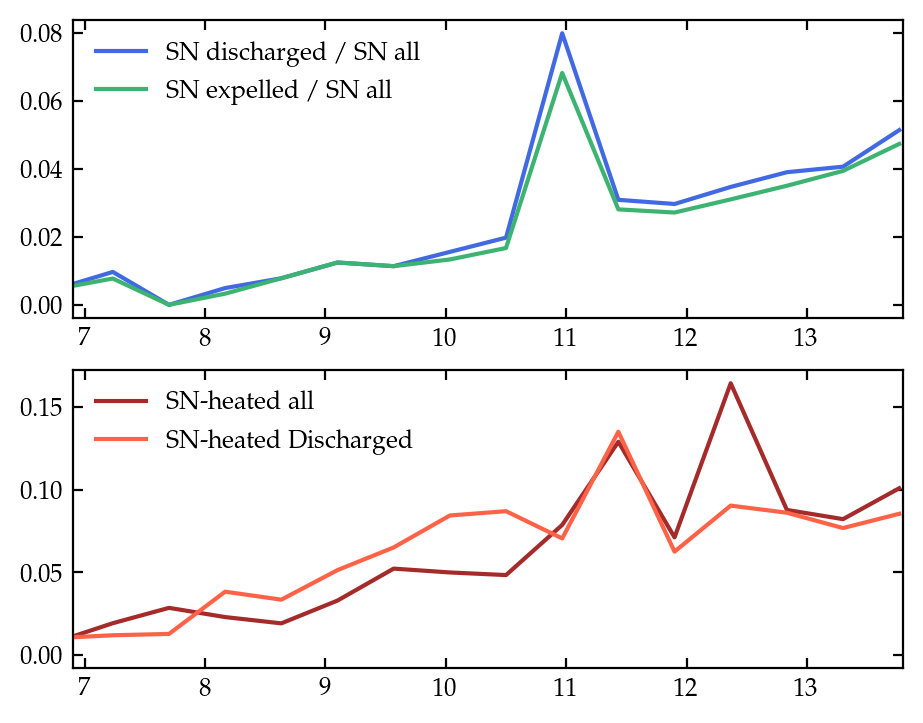

In [49]:
#fraction of discharged/heated (archive)
# all discharged gas
bins = 30
rangeMax = 14
dist, x = np.histogram(more_discharged.time, bins=bins, range=(0,rangeMax))

# all expelled gas
expt, x = np.histogram(more_expelled.time, bins=bins, range=(0,rangeMax))

# all snheated gas
snt, x = np.histogram(more_heated.time, bins=bins, range=(0,rangeMax))

# computing fraction dist/snt at each radial position.
fracDis = np.array([])
fracExp = np.array([])

for i in range(0, bins):
    ratioDis = dist[i]/snt[i]
    ratioExp = expt[i]/snt[i]
    fracDis = np.append(fracDis,ratioDis)
    fracExp = np.append(fracExp,ratioExp)
    i += 1


fig, ax = plt.subplots(2,1,figsize = (4.5,3.5))
# fraction sne/all:
bincenters = 0.5*(x[1:] + x[:-1])
ax[0].plot(bincenters, fracDis, c = 'royalblue', label='SN discharged / SN all')
bincenters = 0.5*(x[1:] + x[:-1])
ax[0].plot(bincenters, fracExp, c = 'mediumseagreen', label='SN expelled / SN all')
ax[0].set_xlim(np.min(more_discharged.time), np.max(more_discharged.time))
ax[0].legend()

# mass distributions:
# all snheated gas
snt, x = np.histogram(more_heated.time, bins=bins, weights=wt(more_heated), range=(0,rangeMax))

_, discharged = read_one_discharged('h148_10')
heated = discharged[discharged['snHeated']==True]
sndischarged, x = np.histogram(heated.time, bins=bins, weights=wt(heated),range=(0,rangeMax))

bincenters = 0.5*(x[1:] + x[:-1])
ax[1].plot(bincenters, snt, label='SN-heated all', c='brown')
ax[1].plot(bincenters, sndischarged, label='SN-heated Discharged', c='tomato')
ax[1].set_xlim(np.min(more_discharged.time), np.max(more_discharged.time))
ax[1].legend()

In [61]:
np.unique(np.array([[1,2],[1,3],[1,3],[2,1]]), axis=0)

array([1, 2, 3])

In [155]:
a = np.array([1,2,3,4,5,6,7])
a[np.array([1,2])-1]

array([1, 2])

In [252]:
particles = read_tracked_particles(sim, haloid)
heated_all = calc_snHeated(particles)

> Returning <tracked_particle> dataset <


In [254]:
len(heated_all)

59402

In [255]:
len(heated_dis)

4600

In [263]:
_, data = read_one_discharged('h148_10')

> Returning (predischarged, discharged, hot_predischarged) for satellite h148_10 <


In [275]:
data[(data['snHeated']==True)&(data['pid']==11128650)]

,time,pid,rho,temp,mass,coolontime,r,r_per_Rvir,x,y,...,host_r_gal,sat_disk,sat_halo,host_disk,host_halo,other_sat,IGM,sat_Mvir,angle,snHeated
191726,7.039793,11128650,0.014274,848226.437500,28737.282569,7.038629,1.890654,0.048105,1.257500,-1.266903,...,20.521985,False,False,False,False,False,True,1.519716e+10,135.178093,True
549904,8.608831,11128650,0.068709,10580.125000,21314.078491,8.494868,3.235061,0.069804,-2.949189,0.311034,...,20.248449,False,True,False,False,False,False,1.841544e+10,73.066572,True
728972,9.490994,11128650,0.007935,13453.203125,21397.014678,9.356826,5.665785,0.121458,4.394128,1.785799,...,18.284842,False,True,False,False,False,False,1.643150e+10,127.688814,True
907993,10.352954,11128650,0.029203,10850.455078,13550.131944,10.011713,6.535957,0.139540,5.873261,2.688814,...,18.796600,False,True,False,False,False,False,1.489011e+10,57.333581,True
1443902,12.150951,11128650,0.081856,9371.289062,13594.150831,12.111895,4.929128,0.103924,4.405070,1.758673,...,19.815729,False,True,False,False,False,False,1.288683e+10,64.431303,True
1621379,12.938837,11128650,0.001374,12028.806641,13736.994394,12.750788,12.050669,0.253640,-10.765113,1.411835,...,17.456248,False,True,False,False,False,False,1.215825e+10,19.806317,True


In [266]:
particles = read_tracked_particles('h148',10)
data2 = calc_snHeated(particles)

> Returning <tracked_particle> dataset <


In [285]:
test = particles[particles.pid==11128650]
# test = read_tracked_particles('h148', 10)
dtype = [('index', int), ('pid', int), ('time', float), ('coolontime', float)]
testarray=np.array(list(zip(test.index, *map(test.get, ['pid','time','coolontime']))), dtype=dtype)
#print(testarray)
testarray=testarray[testarray['time']>testarray['coolontime']]
helper1, helper2 = np.unique(testarray['coolontime'], return_index = True)
testunique = np.sort(testarray[helper2], order=['pid','time'])
print(testunique)
pids = np.unique(testunique['pid'])
index = np.array([])
for pid in pids:
    dat = testunique[testunique['pid']==pid]
    timebefore = dat['time'][:-1]
    heatedArray = dat[1:][dat['coolontime'][1:]>timebefore]
    heatedIndex = heatedArray['index'].astype(int)
    index = np.append(index, heatedIndex)
heated = test[test.index.isin(index)]  

> Returning <tracked_particle> dataset <
[(     0,   376519, 6.47413103, 0.        )
 (     1,   419298, 6.47413103, 3.59668698)
 (268656,   702739, 7.33609179, 7.25832746) ...
 ( 89508, 20547672, 6.47413103, 4.93559639)
 ( 89512, 20564801, 6.47413103, 6.40874561)
 ( 89533, 20692705, 6.47413103, 4.18928351)]


In [288]:
#remake this function
#iterate detection process by pids

index = np.array([]) #initialize

data = particles[particles['pid']==11128650]
#create a structured array, containing index of dataframe, pid, time, and coolontime
dtype = [('index', int), ('pid', int), ('time', float), ('coolontime', float)]
structureArray=np.array(list(zip(data.index, *map(data.get, ['pid','time','coolontime']))), dtype=dtype)
#limit to after being heated (avoid mistakingly take the row heated at the same timestep)
heatedArray=structureArray[structureArray['time']>structureArray['coolontime']]
#extract the list of unique coolontime, sorted by pid and time
helper1, helper2 = np.unique(heatedArray['coolontime'], return_index = True)
heatedunique = np.sort(heatedArray[helper2], order=['pid','time'])

timebefore = heatedunique['time'][:-1]
#find sn-heated list by comparing the time before and coolontime
heatedLocal = heatedunique[1:][heatedunique['coolontime'][1:]>timebefore]
indexLocal = heatedLocal['index'].astype(int)
index = np.append(index, indexLocal)
#based on detected indices, find the designated rows from original dataframe
heated = particles[particles.index.isin(index)] 

In [289]:
heated[heated.pid == 11128650]

,time,pid,rho,temp,mass,coolontime,r,r_per_Rvir,x,y,...,dt,r_gal,host_r_gal,sat_disk,sat_halo,host_disk,host_halo,other_sat,IGM,sat_Mvir
191726,7.039793,11128650,0.014274,848226.437500,28737.282569,7.038629,1.890654,0.048105,1.257500,-1.266903,...,0.134681,0.808819,20.521985,False,False,False,False,False,True,1.519716e+10
370820,7.767072,11128650,0.225140,9764.855469,21080.136030,7.720452,1.643590,0.036507,-1.210065,1.091757,...,0.430980,1.052765,18.543060,True,False,False,False,False,False,1.962724e+10
549904,8.608831,11128650,0.068709,10580.125000,21314.078491,8.494868,3.235061,0.069804,-2.949189,0.311034,...,0.410778,2.677134,20.248449,False,True,False,False,False,False,1.841544e+10
728972,9.490994,11128650,0.007935,13453.203125,21397.014678,9.356826,5.665785,0.121458,4.394128,1.785799,...,0.430980,3.898846,18.284842,False,True,False,False,False,False,1.643150e+10
907993,10.352954,11128650,0.029203,10850.455078,13550.131944,10.011713,6.535957,0.139540,5.873261,2.688814,...,0.430980,1.948417,18.796600,False,True,False,False,False,False,1.489011e+10
1443902,12.150951,11128650,0.081856,9371.289062,13594.150831,12.111895,4.929128,0.103924,4.405070,1.758673,...,0.074075,2.438901,19.815729,False,True,False,False,False,False,1.288683e+10
1621379,12.938837,11128650,0.001374,12028.806641,13736.994394,12.750788,12.050669,0.253640,-10.765113,1.411835,...,0.430980,3.480204,17.456248,False,True,False,False,False,False,1.215825e+10


In [273]:
count = Counter(data[(data['snHeated']==True)]['pid'])-Counter(data2.pid)

In [274]:
print(count)

Counter({11128650: 6, 13688739: 6, 15692783: 6, 11111758: 5, 11131126: 5, 11131748: 5, 11132618: 5, 11148073: 5, 11540737: 5, 11545625: 5, 11551011: 5, 11551696: 5, 11552006: 5, 13229373: 5, 13242455: 5, 13242795: 5, 13244430: 5, 13245317: 5, 13245903: 5, 13249451: 5, 13259771: 5, 13265969: 5, 13279156: 5, 13661043: 5, 13662952: 5, 13663643: 5, 13664100: 5, 13666049: 5, 13672389: 5, 13674715: 5, 13676532: 5, 13676898: 5, 13677670: 5, 13678069: 5, 13678702: 5, 13683683: 5, 13685826: 5, 13688703: 5, 15275117: 5, 15677118: 5, 15679122: 5, 15679427: 5, 15686240: 5, 15686798: 5, 15686799: 5, 15687191: 5, 15688373: 5, 15688929: 5, 15692674: 5, 15697941: 5, 15699556: 5, 15700764: 5, 15701479: 5, 15701710: 5, 17392171: 5, 17421206: 5, 17422448: 5, 17422545: 5, 17423845: 5, 9719283: 4, 11093765: 4, 11100411: 4, 11105859: 4, 11108590: 4, 11108779: 4, 11109042: 4, 11109159: 4, 11109685: 4, 11109815: 4, 11109961: 4, 11111990: 4, 11113060: 4, 11114434: 4, 11117367: 4, 11117747: 4, 11119856: 4, 1112